In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import json
import os
from cv2 import resize

Load training and validation datasets.

In [2]:
img_height = 224
img_width = 224


train_ds = tf.keras.utils.image_dataset_from_directory(
  '../input/pytorch-challange-flower-dataset/dataset/train',
  validation_split=None,
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '../input/pytorch-challange-flower-dataset/dataset/valid',
  validation_split=None,
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)


Found 6552 files belonging to 102 classes.


2022-08-16 02:02:52.198854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 02:02:52.324163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 02:02:52.325130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 02:02:52.328486: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 818 files belonging to 102 classes.


Read the category to name dictionary.

Note that the internal label numbers created by Tensorflow is different from the respective directory numbers.

E.g. images in folder named '4' might be labeled 35 in the internal label list.

So we need several helper functions to do the convertion for testing.

In [3]:
with open('../input/pytorch-challange-flower-dataset/cat_to_name.json') as f:
    cat_to_name = json.load(f)

# class_names are inferred labels from folder names of type string (e.g. '0')
# the internal integer label values are different from the values in the JSON
# so these functions are necessary

# convert internal tag integer to readable flower name
def flower_name(val):
    return cat_to_name[train_ds.class_names[val]]

# convert label from CSV to internal label value
def to_internal_tag(name_tag):
    return train_ds.class_names.index(str(name_tag))

In [4]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [5]:
# the model: using VGG16 as a base model and apply transfer learning on it

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(102)(x)
model = tf.keras.Model(inputs, outputs)

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Here I only ran for 20 epochs, but results can become much better if you run more epochs.

In [7]:
num_epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
        )
    ]
)

Epoch 1/20


2022-08-16 02:02:56.965165: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-16 02:02:58.862387: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


205/205 [==============================] - 41s 146ms/step - loss: 14.1588 - accuracy: 0.0165 - val_loss: 8.8491 - val_accuracy: 0.0342
Epoch 2/20
205/205 [==============================] - 20s 95ms/step - loss: 10.7756 - accuracy: 0.0285 - val_loss: 6.7552 - val_accuracy: 0.0758
Epoch 3/20
205/205 [==============================] - 19s 88ms/step - loss: 9.0036 - accuracy: 0.0574 - val_loss: 5.3993 - val_accuracy: 0.1479
Epoch 4/20
205/205 [==============================] - 19s 91ms/step - loss: 7.5195 - accuracy: 0.0954 - val_loss: 4.4142 - val_accuracy: 0.2421
Epoch 5/20
205/205 [==============================] - 18s 86ms/step - loss: 6.3819 - accuracy: 0.1392 - val_loss: 3.6569 - val_accuracy: 0.3142
Epoch 6/20
205/205 [==============================] - 19s 87ms/step - loss: 5.4367 - accuracy: 0.1848 - val_loss: 3.0631 - val_accuracy: 0.3961
Epoch 7/20
205/205 [==============================] - 19s 92ms/step - loss: 4.7177 - accuracy: 0.2364 - val_loss: 2.5974 - val_accuracy: 0.4756


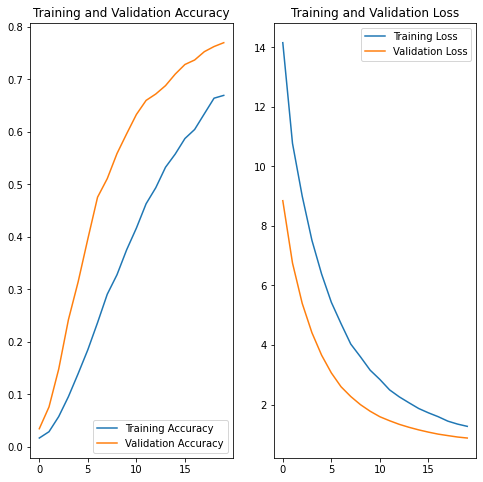

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Choose a random image from the unlabeled test set and predict its type.

image_07241.jpg most likely belongs to gaura with a 90.18 percent confidence.


(-0.5, 223.5, 223.5, -0.5)

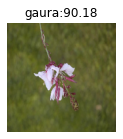

In [9]:
img_name = random.choice(os.listdir('../input/pytorch-challange-flower-dataset/dataset/test/'))
img_path = '../input/pytorch-challange-flower-dataset/dataset/test/' + img_name

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "{} most likely belongs to {} with a {:.2f} percent confidence."
    .format(img_name, flower_name(np.argmax(score)), 100 * np.max(score))
)

plt.figure(figsize=(2, 2))
plt.imshow((img_array[0].numpy()).astype('uint8'))
plt.title("{}:{:.2f}".format(flower_name(np.argmax(score)), 100 * np.max(score)))
plt.axis('off')

Here we use data from another larger dataset with the same labels for testing accuracy.

In [10]:
test_x = [resize(plt.imread('../input/flower-classification-dataset/files/0.jpg'), dsize=(img_height, img_width))]
for i in range(1, 20000): # by changing the value here you can change the scale of accuracy test
    try:
        test_x.append(resize(plt.imread('../input/flower-classification-dataset/files/{:d}.jpg'.format(i)), dsize=(img_height, img_width)))
    except FileNotFoundError:
        break
test_x = np.array(test_x)

test_y = np.array([to_internal_tag(name_tag) for name_tag in np.loadtxt(
    '../input/flower-classification-dataset/labels.csv',
    delimiter=',',
    skiprows=1,
    usecols=(1),
    dtype='uint8')[:len(test_x)]])

print('Loaded {:d} test images.'.format(len(test_y)))

Loaded 18540 test images.


Do the prediction. I use `predict()` instead of `evaluate()` so that I can do evaluation by myself later.

In [11]:
pred_y = np.array([np.argmax(logits) for logits in model.predict(test_x)])
f_accuracy = tf.keras.metrics.Accuracy()
f_accuracy.update_state(test_y, pred_y)
print('Overall accuracy of test set: {:.4f}'.format(f_accuracy.result().numpy()))

2022-08-16 02:12:29.838898: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2790789120 exceeds 10% of free system memory.
2022-08-16 02:12:33.137448: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2790789120 exceeds 10% of free system memory.


Overall accuracy of test set: 0.7372


Plot a graph of the confusion matrix.

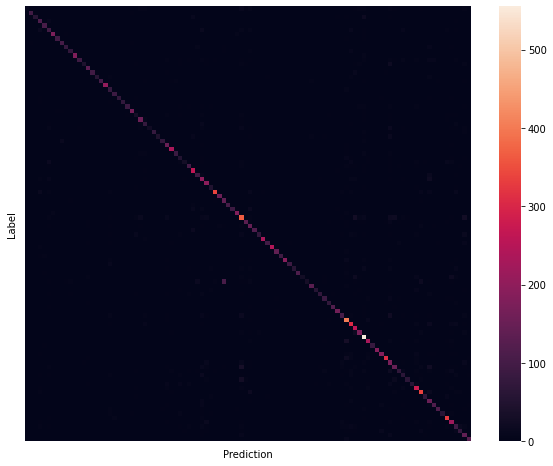

In [12]:
import seaborn as sns
def show_confusion_matrix(cm):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=False, yticklabels=False, 
              annot=False)
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

confusion_matrix = tf.math.confusion_matrix(test_y, pred_y)
show_confusion_matrix(confusion_matrix)

Calculate accuracy of each category and print categories whose prediction accuracy is lower than 60%.

You can see that there are 27 categories having low accuracy, but this number will quickly drop to less than 15 given more training epochs.

In [13]:
acc = []
for i, preds in enumerate(confusion_matrix):
    acc.append(preds[i]/np.sum(preds))
    
for i, a in enumerate(acc):
    if a < 0.6:
        print('{}: {:.4f}'.format(flower_name(i), a))

pink primrose: 0.0778
blanket flower: 0.5135
snapdragon: 0.4747
peruvian lily: 0.4785
balloon flower: 0.3964
stemless gentian: 0.5667
canterbury bells: 0.3556
garden phlox: 0.2157
mexican aster: 0.4889
siam tulip: 0.5484
sweet pea: 0.2381
bolero deep blue: 0.5444
pelargonium: 0.4506
japanese anemone: 0.4603
silverbush: 0.2393
californian poppy: 0.1385
spring crocus: 0.5833
bearded iris: 0.5691
azalea: 0.4769
hibiscus: 0.4916
columbine: 0.3641
desert-rose: 0.4514
tree mallow: 0.4848
magnolia: 0.4097
ball moss: 0.5619
camellia: 0.4541
mallow: 0.4933
